<h3 style="text-align:justify; background-color:RGB(135, 206, 250);font-size:25px;font-family:Roboto"> Modélisation

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto">  Importations des librairies nécessaires

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from plotly.subplots import make_subplots

from yellowbrick.regressor import ResidualsPlot
import os
import dask.dataframe as dd #pour importer rapidement la base de données
import sys

In [4]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [5]:
import scipy.stats as stats
from sklearn.metrics import make_scorer
from sklearn.linear_model import Lasso

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto"> Importation de la base

In [11]:
project_root =Path.cwd().parent

In [17]:
file_path1 = project_root / "bases" / "datafare_FINALE.csv"

In [21]:
data2=pd.read_csv(file_path1)

In [27]:
data2 = data2.drop("fare_bin", axis=1)

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto"> Separation des données: données explicatives et  expliquées

In [29]:
y_data = data2[['fare_amount']]
x_data = data2.drop(columns=['fare_amount','pickup_datetime','day_of_week','key','season','hour'])

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto">Division des données pour l'entrainement et le test

In [31]:
X_train, X_test, y_train, y_test = train_test_split(x_data,y_data, test_size=0.2, random_state=42)

 <h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto">Mise en place des modeles

Création d'une fonction Python pour afficher des données dans un tableau interactif et esthétique à l'aide de Plotly

In [40]:
def create_table(data, c=300, k=100):
    # Si les données sont sous forme de dictionnaire, les convertir en DataFrame
    if isinstance(data, dict):
        data = pd.DataFrame(data)
    
    # Formater les colonnes numériques pour afficher deux décimales
    for col in data.columns:
        if data[col].dtype in ['float64', 'int64']:  # Vérifier si la colonne contient des valeurs numériques
            data[col] = data[col].apply(lambda x: f"{x:.2f}")
    
    # Création du tableau Plotly avec un design plus esthétique
    fig = go.Figure(data=[go.Table(
        header=dict(
            values=data.columns,  # Utilise les noms des colonnes comme en-têtes
            align='center',  # Alignement des en-têtes au centre
            fill_color='rgb(48, 63, 159)',  # Couleur de fond des en-têtes (bleu foncé)
            font=dict(size=14, color='white', family='Arial, sans-serif'),  # Police en blanc et plus grande
            height=40,  # Hauteur de l'en-tête
            line_color='rgb(0, 0, 0)',  # Bordure des en-têtes
            line_width=1  # Épaisseur de la bordure
        ),
        cells=dict(
            values=[data[col] for col in data.columns],  # Remplissage des cellules avec les données
            align=['center']*len(data.columns),  # Aligner les colonnes au centre
            fill_color=['#f9f9f9', '#ffffff'],  # Couleur alternée des lignes (gris clair et blanc)
            font=dict(size=12, color='rgb(0, 0, 0)', family='Arial, sans-serif'),  # Police noire et plus petite
            height=40,  # Hauteur des lignes
            line_color='rgb(204, 204, 204)',  # Couleur des bordures des cellules
            line_width=1  # Épaisseur de la bordure des cellules
        ),
        columnwidth=[c, k],  # Largeur des colonnes
    )])

    # Affichage du tableau
    fig.show()
    return fig

Fonction d'évaluation des performances d'un modèle à l'aide des métriques : MAE, MSE, RMSE et R².

In [43]:
def evaluate_fitted_model_simple(mod, X_train, y_train,titre="Train"):
  
    # Prédictions
    y_train_pred = mod.predict(X_train)
    
    # Calcul des métriques
    metrics = {
        'Dataset': [titre],
        'MAE': [mean_absolute_error(y_train, y_train_pred)],
        'MSE': [mean_squared_error(y_train, y_train_pred)],
        'RMSE': [np.sqrt(mean_squared_error(y_train, y_train_pred))],
        'R2': [r2_score(y_train, y_train_pred)]
    }
    
    # Créer un DataFrame avec les métriques
    metrics_df = pd.DataFrame(metrics)
    
    return metrics_df



Fonction pour aplatir les prédictions et les valeurs réelles dans un format compatible pour l'analyse.

In [46]:
def flatten_predictions(y_test, y_pred, pred_column_name='fare_amount'):
    
    y_pred_df = pd.DataFrame(y_pred, columns=[pred_column_name])
    y_test_flat = np.ravel(y_test)
    y_pred_flat = np.ravel(y_pred_df)
    return y_test_flat, y_pred_flat

Fonction pour calculer les résidus entre les valeurs réelles et les prédictions.

In [49]:
def cal_residus(y_test, y_pred):
    y_test_flat, y_pred_flat=flatten_predictions(y_test, y_pred)
    return y_test_flat-y_pred_flat

Fonction pour visualiser les prédictions par rapport aux valeurs réelles avec une ligne idéale.

In [52]:
import matplotlib.pyplot as plt

def plot_scatter_comparison(y_train_pred, y_train,y_test_pred, y_test):
    
   
    # Visualisation des scatter plots
    plt.figure(figsize=(12, 6))

    # Scatter plot d'entraînement
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, alpha=0.6, color='skyblue')
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='black', linestyle='--')  # Ligne parfaite
    plt.title('Prédictions - Entraînement')
    plt.xlabel('Valeurs réelles')
    plt.ylabel('Valeurs prédites')

    # Scatter plot de test
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, alpha=0.6, color='salmon')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--')  # Ligne parfaite
    plt.title('Prédictions - Test')
    plt.xlabel('Valeurs réelles')
    plt.ylabel('Valeurs prédites')

    plt.tight_layout()
    plt.show()


Fonction pour visualiser la distribution des erreurs (résidus) à l'aide d'un histogramme.

In [55]:

def plot_prediction_errors(train_error,test_error):

    # Visualisation des erreurs
    plt.figure(figsize=(12, 6))

    # Erreur d'entraînement
    plt.subplot(1, 2, 1)
    plt.hist(train_error, bins=30, color='skyblue', edgecolor='black')
    plt.title('Erreur de prédiction - Entraînement')
    plt.xlabel('Erreur')
    plt.ylabel('Fréquence')

    # Erreur de test
    plt.subplot(1, 2, 2)
    plt.hist(test_error, bins=30, color='salmon', edgecolor='black')
    plt.title('Erreur de prédiction - Test')
    plt.xlabel('Erreur')
    plt.ylabel('Fréquence')

    plt.tight_layout()
    plt.show()




# Fonction pour visualiser la distribution cumulée des résidus avec une courbe CDF.

In [58]:
def plot_cumulative_residuals(y_test, y_pred):
    y_train_flat,y_pred1_flat=flatten_predictions(y_test,y_pred)
    residuals =y_train_flat - y_pred1_flat
    sorted_residuals = np.sort(residuals)
    cdf = np.arange(1, len(sorted_residuals) + 1) / len(sorted_residuals)

    plt.figure(figsize=(10, 6))
    plt.plot(sorted_residuals, cdf, color='green', lw=2, label='CDF des résidus')
    plt.plot(sorted_residuals, cdf, 'o', color='green', markersize=4, alpha=0.6)
    plt.axhline(0.5, color='black', linestyle='--', lw=1)
    plt.axvline(0, color='red', linestyle='--', lw=1)
    plt.xlabel('Résidus', fontsize=12)
    plt.ylabel('CDF', fontsize=12)
    plt.title('Distribution cumulée des résidus', fontsize=14)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

Le test de Kolmogorov-Smirnov (KS) est une alternative plus rapide au test de Shapiro-Wilk et peut être utilisé pour tester si une distribution suit une loi normale.

In [61]:
from scipy.stats import kstest
import numpy as np

def test_normalite_residus_ks(residuals):
    # Calcul de la statistique et de la p-value du test KS
    stat, p_value = kstest(residuals, 'norm', args=(np.mean(residuals), np.std(residuals)))
    
    # Interprétation
    interpretation = (
        "Les résidus suivent une distribution normale (p > 0.05)."
        if p_value > 0.05
        else "Les résidus ne suivent pas une distribution normale (p ≤ 0.05)."
    )
    
    # Résultats
    results = {
        "statistique": stat,
        "p_value": p_value,
        "interpretation": interpretation
    }
    
    # Affichage des résultats
    print(f"Statistique KS: {stat:.4f}, p-value: {p_value:.4f}")
    print(interpretation)
    
    return results

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto">Test d'autocorrélation des résidus (Durbin-Watson)

In [64]:
from statsmodels.stats.stattools import durbin_watson

def test_autocorrelation_residus(residuals):
    
    # Calcul de la statistique de Durbin-Watson
    dw_stat = durbin_watson(residuals)
    
    # Interprétation
    if 1.5 <= dw_stat <= 2.5:
        interpretation = "Pas d'autocorrélation détectée (statistique dans [1.5, 2.5])."
    else:
        interpretation = "Autocorrélation détectée (statistique hors de [1.5, 2.5])."
    
    # Résultats
    results = {
        "statistique": dw_stat,
        "interpretation": interpretation
    }
    
    # Affichage des résultats
    
    print(interpretation)
    
    return results

## Représentation des scores en fonctioon des valeurs d'alpha

In [68]:
def plot_grid_search_results(grid_search, param_name=None, score_name="mean_test_score", ylabel="R2 Score"):

    if not param_name:
        param_name = list(grid_search.param_grid.keys())[0]  # Use the first parameter if none is specified
    
    # Extract the results
    results = grid_search.cv_results_
    param_values = results[f"param_{param_name}"]
    mean_scores = results[score_name]
    
    # Plot the results
    plt.figure(figsize=(8, 6))
    plt.plot(param_values, mean_scores, marker='o', label="Validation score")
    plt.xlabel(param_name)
    plt.ylabel(ylabel)
    plt.title(f"{ylabel} vs {param_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

## le QQplot

In [446]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

def plot_qqplot_residuals(train_residuals, test_residuals, train_title="QQ-Plot Résidus - Entraînement", 
                          test_title="QQ-Plot Résidus - Test"):
   
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # QQ-Plot des résidus d'entraînement
    sm.qqplot(train_residuals, line='45', fit=True, ax=axes[0])
    axes[0].set_title(train_title)
    axes[0].grid(True)
    
    # QQ-Plot des résidus de test
    sm.qqplot(test_residuals, line='45', fit=True, ax=axes[1])
    axes[1].set_title(test_title)
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()


<h3 style="text-align:justify; background-color:RGB(135, 206, 250);font-size:25px;font-family:Roboto">Modele de regression simple

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto">Mise en place du pipeline pour le modele

In [72]:
variable_code=[  'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance', 'near_airport',
        'hour_cos', 'is_holiday'
                                 ]

In [210]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), variable_code)
    ],
    remainder='passthrough'  # Conserver les autres colonnes telles quelles
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression()) 
])

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto"> Entrainement du modele 

In [213]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['pickup_longitude',
                                                   'pickup_latitude',
                                                   'dropoff_longitude',
                                                   'dropoff_latitude',
                                                   'passenger_count',
                                                   'distance', 'near_airport',
                                                   'hour_cos',
                                                   'is_holiday'])])),
                ('model', LinearRegression())])

### Nous allons donner un nom a notre modele

In [215]:
model = pipeline.named_steps['model']

In [218]:
preprocessor.transformers_[0][2] 

['pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count',
 'distance',
 'near_airport',
 'hour_cos',
 'is_holiday']

In [220]:
pipeline.named_steps['model'].coef_

array([[ 0.28772963,  0.31375316, -0.29897518, -0.53753792,  0.04234807,
         9.88411433,  0.20117531, -0.68597759, -0.1040303 ]])

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto">Determination des coefficients des variables explicatives

In [223]:
coef = model.coef_
variables = X_train.columns  # Noms des variables explicatives

# Créer un DataFrame pour afficher les coefficients
# Récupérer les coefficients
coef_df = pd.DataFrame({
    'Variable': variable_code,
    'Coefficient': coef[0]
})


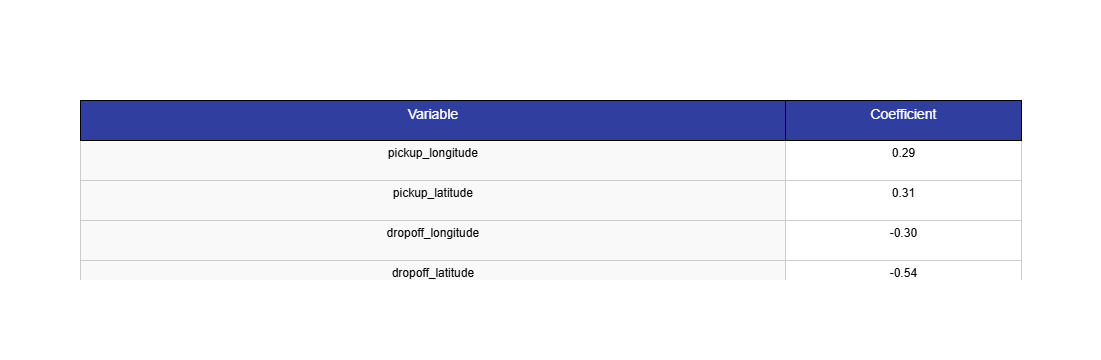

In [225]:
tableau1=create_table(coef_df)

In [422]:
tableau1.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),  # Marges à zéro
    autosize=True,  # Ajuste automatiquement la taille
    paper_bgcolor='white'  # Définir la couleur de fond pour éviter l'espace blanc autour
)

# Exporter l'image
tableau1.write_image("table_CR.png", scale=2, width=500, height=400)

- *Effet de la Localisation* : Les coefficients de pickup_longitude, pickup_latitude, dropoff_longitude, et dropoff_latitude montrent que la localisation géographique de la prise en charge et de la dépose a un impact significatif sur le prix de la course. Les courses commençant à des longitudes et latitudes plus élevées sont plus coûteuses, tandis que celles se terminant à des longitudes et latitudes plus élevées sont moins coûteuses.

- *Effet du Nombre de Passagers* : Le coefficient de passenger_count indique que le nombre de passagers a un effet positif mais modeste sur le prix de la course.

- *Effet de la Distance* : Le coefficient de distance montre que la distance parcourue est le facteur le plus influent sur le prix de la course, ce qui est logique car les courses plus longues nécessitent plus de temps et de carburant.

- *Effet de la Proximité de l'Aéroport* : Le coefficient de near_airport suggère que les courses près de l'aéroport sont légèrement plus coûteuses, probablement en raison d'une demande accrue ou de frais supplémentaires.

- *Effet de l'Heure de la Journée* : Le coefficient de hour_cos indique que les courses pendant les heures les nuits sont moins coûteuses, ce qui pourrait refléter des périodes de faible demande.

- *Effet des Jours Fériés* : Le coefficient de is_holiday montre que les courses pendant les jours fériés sont légèrement moins coûteuses, peut-être en raison d'une demande réduite ou de promotions spéciales.

<h3 style="text-align:justify; background-color:RGB(135, 206, 250);font-size:25px;font-family:Roboto">Prédiction et calcul des résidus avec les données d'entrainement

In [120]:
y_pred = pipeline.predict(X_train)  
y_pred_test_s=pipeline.predict(X_test)

In [122]:
residus_s=cal_residus( y_train,y_pred)
residus_test_s=cal_residus(y_test,y_pred_test_s)

In [124]:
ytf,ypf=flatten_predictions(y_train,y_pred)
ytff,tff=flatten_predictions(y_test,y_pred_test_s)

<h3 style="text-align:justify; background-color:RGB(135, 206, 250);font-size:25px;font-family:Roboto"> Evaluation du modele

In [102]:
error_r1=evaluate_fitted_model_simple(pipeline,X_train,y_train)

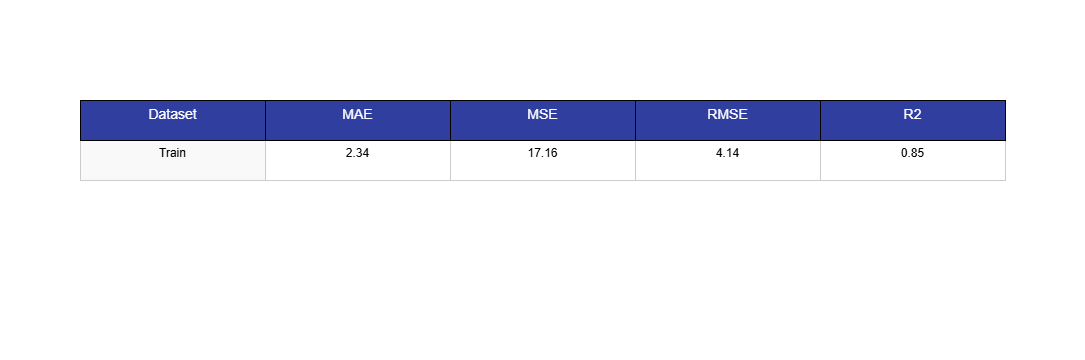

In [104]:
r=create_table(error_r1,10,10)

In [106]:
error_test_r1=evaluate_fitted_model_simple(pipeline,X_test,y_test,"test")

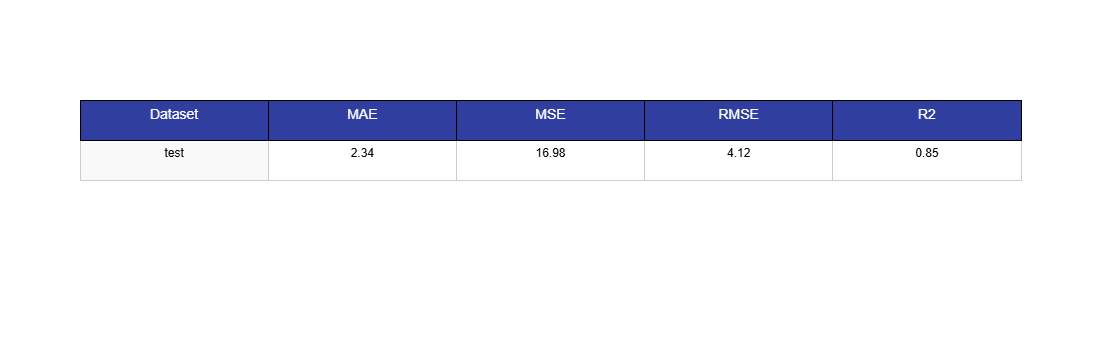

In [108]:
y=create_table(error_test_r1,10,10)

- Performance Constante : Les métriques MAE, MSE, RMSE et R² sont très similaires entre les données d'entraînement et de test, ce qui indique que le modèle ne surapprend pas et généralise bien aux nouvelles données.

- Précision des Prédictions : Les valeurs de MAE et RMSE montrent que les prédictions du modèle sont, en moyenne, à environ 2.34 à 4.14 unités de la valeur réelle. Cela peut être considéré comme une bonne précision en fonction du contexte de l'application.

- Capacité Explicative : Un R² de 0.85 indique que le modèle explique une grande partie de la variance des données, ce qui est un bon signe de la qualité du modèle.

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto"> Test de normalité et l'autocorrelation

In [126]:
test_normalite_residus_ks(residus_s)

Statistique KS: 0.1623, p-value: 0.0000
Les résidus ne suivent pas une distribution normale (p ≤ 0.05).


{'statistique': 0.16230454022417773,
 'p_value': 0.0,
 'interpretation': 'Les résidus ne suivent pas une distribution normale (p ≤ 0.05).'}

In [132]:
test_autocorrelation_residus(residus_s)

Pas d'autocorrélation détectée (statistique dans [1.5, 2.5]).


{'statistique': 2.0017709570291813,
 'interpretation': "Pas d'autocorrélation détectée (statistique dans [1.5, 2.5])."}

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto">Représentation du résidus

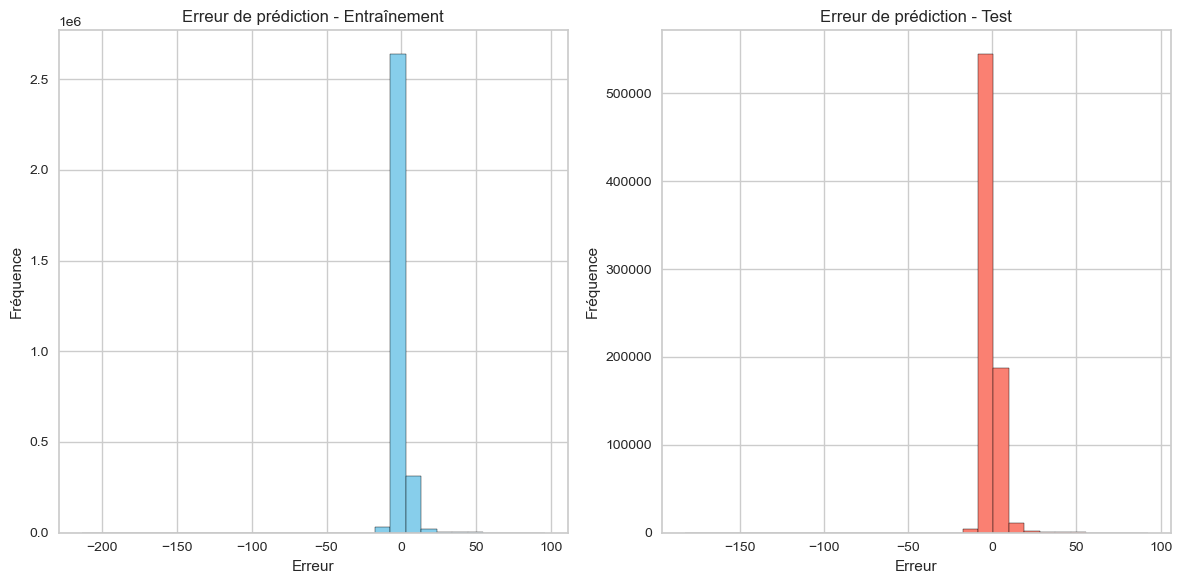

In [281]:
plot_prediction_errors(residus_s,residus_test_s)

Concentration autour de zéro : La forte concentration des résidus autour de zéro dans les deux graphiques indique que le modèle fait des prédictions précises pour la majorité des observations, tant dans l'ensemble d'entraînement que dans l'ensemble de test.

Symétrie : Les distributions des résidus semblent relativement symétriques autour de zéro, ce qui est un bon signe. Cela suggère que le modèle ne sous-estime ni ne sur-estime systématiquement les valeurs réelles.

Valeurs aberrantes : Il y a quelques résidus avec des valeurs plus élevées (positives ou négatives), ce qui indique la présence de valeurs aberrantes ou d'observations pour lesquelles le modèle ne performe pas bien. Cependant, ces cas sont rares par rapport à la majorité des observations.

Performance similaire : La similarité entre les distributions des résidus pour les ensembles d'entraînement et de test suggère que le modèle généralise bien aux nouvelles données et ne surapprend pas les données d'entraînement.

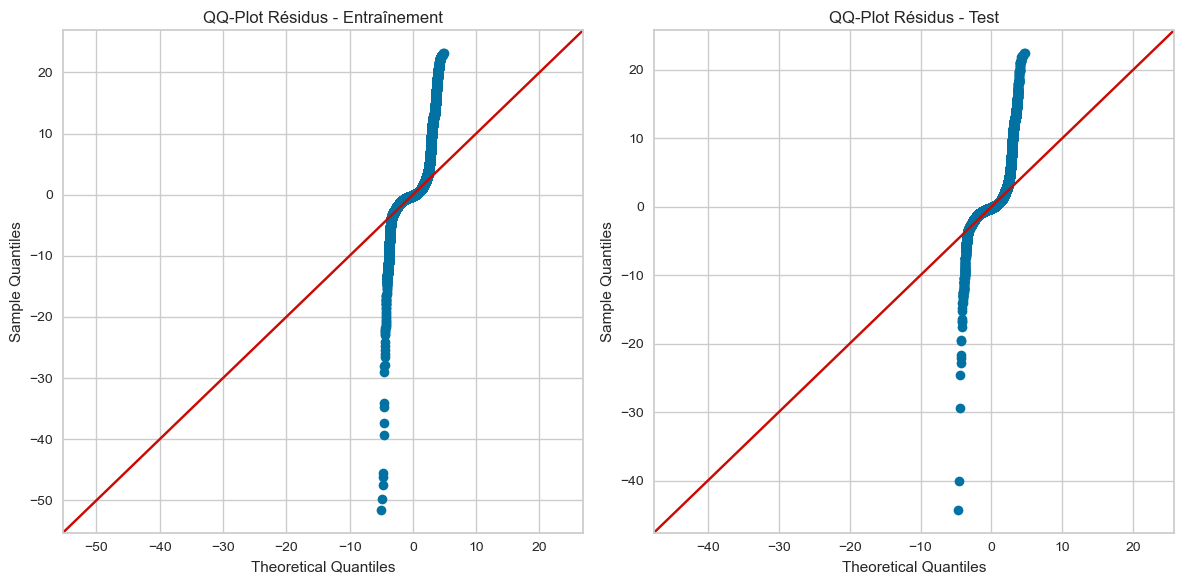

In [448]:
plot_qqplot_residuals(residus_s,residus_test_s)

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto">Representaton des valeurs predictes vers VS

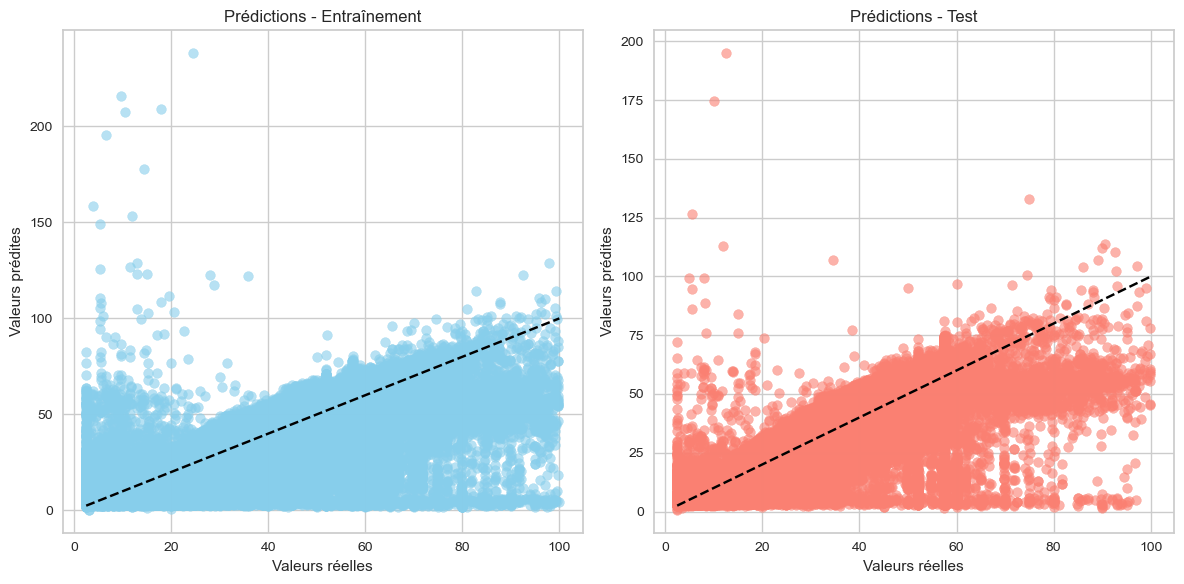

In [256]:
plot_scatter_comparison(ypf,ytf,tff,ytff)

Performance pour les Petites Valeurs :
Le modèle performe bien pour les valeurs réelles inférieures à environ 50, tant dans l'ensemble d'entraînement que dans l'ensemble de test. Les points sont proches de la ligne d'identité (ligne en pointillés), ce qui indique que les prédictions sont proches des valeurs réelles. Cela montre que le modèle est précis pour les petites valeurs.

Performance pour les Grandes Valeurs :
Le modèle sous-estime systématiquement les valeurs réelles élevées (supérieures à 50). Les points s'éloignent de la ligne d'identité, ce qui montre que le modèle prédit des valeurs inférieures aux valeurs réelles pour ces observations. Cette tendance est observée à la fois dans l'ensemble d'entraînement et dans l'ensemble de test.

Dispersion des Prédictions :
La dispersion des points autour de la ligne d'identité est plus large pour les valeurs réelles élevées, ce qui indique une précision moindre du modèle pour ces valeurs. Cela peut être dû à une variabilité plus grande dans les données ou à une moins bonne capacité du modèle à capturer les relations pour ces valeurs.

Consistance entre Entraînement et Test :
Les schémas observés dans les deux graphiques sont similaires, ce qui suggère que le modèle généralise bien aux nouvelles données et ne surapprend pas les données d'entraînement. Les tendances de sous-estimation pour les grandes valeurs et de bonne performance pour les petites valeurs sont cohérentes entre les deux les données.

In [169]:
test_autocorrelation_residus(residuals)

Pas d'autocorrélation détectée (statistique dans [1.5, 2.5]).


{'statistique': array([2.00177096]),
 'interpretation': "Pas d'autocorrélation détectée (statistique dans [1.5, 2.5])."}

<h3 style="text-align:justify; background-color:RGB(135, 206, 250);font-size:25px;font-family:Roboto"> Modele de regression Ridge

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto"> Creation du Pipeline

In [139]:
variables_numeriques = [   'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance', 'near_airport',
        'hour_cos', 'is_holiday']

In [141]:
pipeline_r = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), variables_numeriques)  # Normaliser les variables numériques
        ], 
        remainder='passthrough'  # Laisser les autres colonnes intactes
    )),
    ('ridge', Ridge())  # Modèle Ridge
])

### Les alphas sur lequel chercher le meileur

In [144]:
alpha_values = [18.5,18.4,18,45]

### le mise en place du modele avec 

In [147]:
param_grid_rr = {'ridge__alpha': alpha_values}  # Utilisation de l'étape 'ridge' du pipeline
grid_search_rr = GridSearchCV(pipeline_r, param_grid_rr, cv=5, scoring=make_scorer(r2_score))

In [149]:
X_train.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'distance', 'near_airport',
       'hour_cos', 'is_holiday'],
      dtype='object')

<h3 style="text-align:justify; background-color:RGB(135, 206, 250);font-size:25px;font-family:Roboto"> L'entrainement du modele

In [152]:
grid_search_rr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['pickup_longitude',
                                                                          'pickup_latitude',
                                                                          'dropoff_longitude',
                                                                          'dropoff_latitude',
                                                                          'passenger_count',
                                                                          'distance',
                                                                          'near_airport',
                                                                          'hour_cos',
                                                                          'is_holiday'])])),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [18.5, 18.4, 18, 45]},
             scoring=make_scorer(r2_score, response_method='predict'))

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto">Courbe d'apprentissage pour évaluer les performances du modèle

In [154]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(estimator, X, y, cv=5, scoring='neg_mean_squared_error'):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)
    
    train_scores_mean = -train_scores.mean(axis=1)
    val_scores_mean = -val_scores.mean(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Error', color='blue', marker='o')
    plt.plot(train_sizes, val_scores_mean, label='Validation Error', color='orange', marker='o')
    
    plt.xlabel('Training Set Size')
    plt.ylabel('Error (lower is better)')
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.grid(alpha=0.3)
    plt.show()

# Exemple d'utilisation
# plot_learning_curve(estimator=model, X=X_train, y=y_train, cv=5)


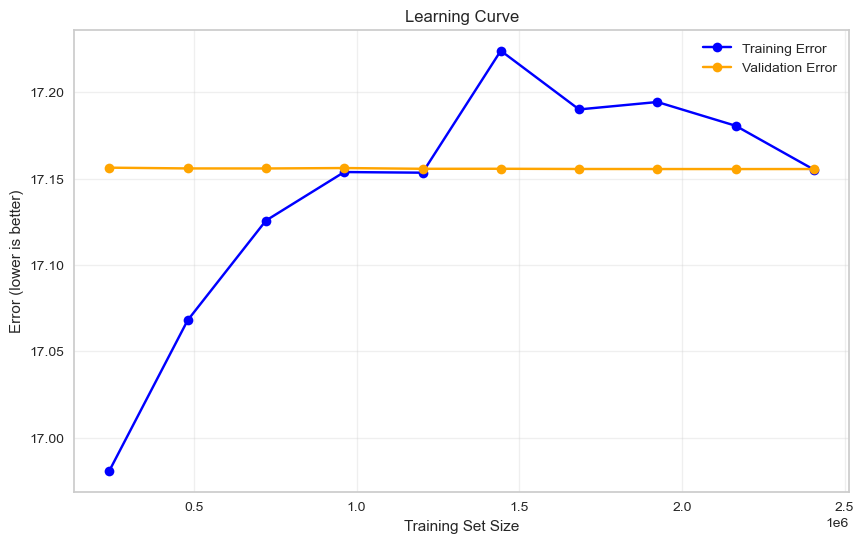

In [155]:
plot_learning_curve(pipeline_r,X_train,y_train)

- Surajustement Léger : L'augmentation initiale de l'erreur d'entraînement suivie d'une stabilisation suggère un léger surajustement. Le modèle s'ajuste trop bien aux données d'entraînement pour les petites tailles d'ensemble, mais cette tendance diminue avec l'augmentation de la taille de l'ensemble.
- Bon Ajustement : L'erreur de validation constante et relativement basse indique que le modèle généralise bien aux données non vues. Cela montre que le modèle de régression Ridge est efficace pour cette tâche, avec une bonne capacité de généralisation.
- Sensibilité à la Taille de l'Ensemble d'Entraînement : Les fluctuations de l'erreur d'entraînement indiquent que le modèle est sensible à la taille de l'ensemble d'entraînement. Cela suggère que la taille de l'ensemble d'entraînement joue un rôle crucial dans la performance du modèle.

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto"> Representation graphique des apha vers r2

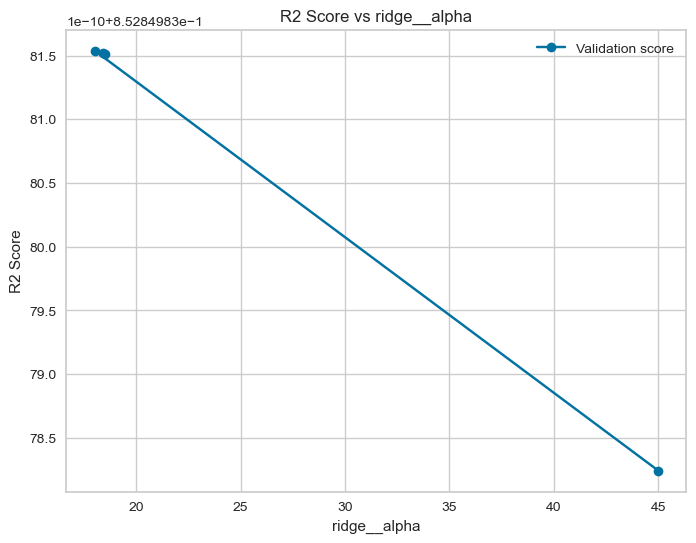

In [158]:
plot_grid_search_results(grid_search_rr)

La courbe tracée révèle une tendance négative claire entre ridge_alpha et le score R². En d'autres termes, à mesure que la valeur de ridge_alpha augmente, le score R² diminue. Plus précisément, le score R² commence à environ 81,5 pour un ridge_alpha de 18 et décroît jusqu'à environ 78,5 pour un ridge_alpha de 45.
La meilleure valeur du paramètre se situe autour de 18

### Chercher le meilleur apha

In [160]:
best_alpha_rr = grid_search_rr.best_params_['ridge__alpha']
print(f"Meilleure valeur pour alpha : {best_alpha_rr}")

Meilleure valeur pour alpha : 18


### Entrainement du modèle avec le meileur alpha

In [162]:
best_model_r = grid_search_rr.best_estimator_

In [163]:
ridge_model_r = best_model_r.named_steps['ridge']

### Les coeficients

In [166]:
coefficients = ridge_model_r.coef_

In [167]:
numerical_coefficients_df = pd.DataFrame({
    'Variable':variables_numeriques,
    'Coefficient': coefficients[0]
})

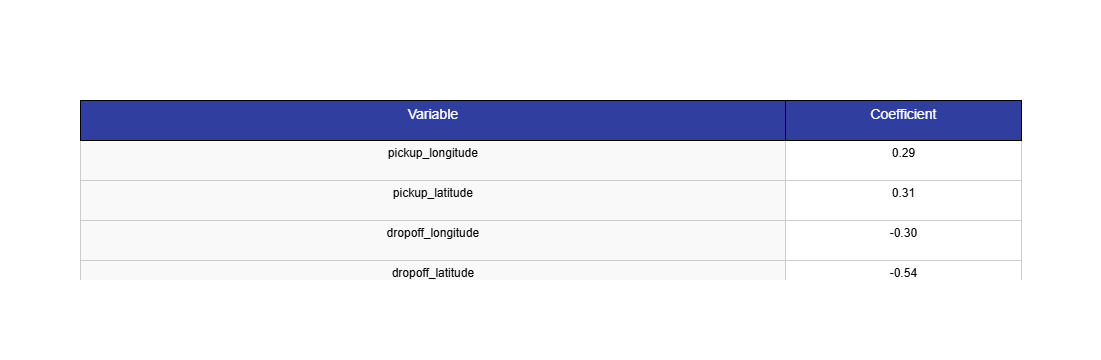

In [168]:
tabl=create_table(numerical_coefficients_df)

Les coefficients du modèle de régression Ridge montrent que la distance parcourue a l'impact le plus significatif sur la variable cible, suivie par les coordonnées de dépose et de prise en charge. Les autres variables, telles que la proximité de l'aéroport, le nombre de passagers, et les jours fériés, ont des effets moins prononcés mais néanmoins notables sur la variable cible. 

In [169]:
tabl.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),  # Marges à zéro
    autosize=True,  # Ajuste automatiquement la taille
    paper_bgcolor='white'  # Définir la couleur de fond pour éviter l'espace blanc autour
)

# Exporter l'image
tabl.write_image("table_CR_ridge.png", scale=2, width=500, height=400)

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto">Prédictions et calcul des résidus.

In [171]:
y_pred2=best_model_r.predict(X_train)
y_pred_test_la=best_model_r.predict(X_test)

In [172]:
residus_ridge=cal_residus( y_train,y_pred2)
residus_test_ridge=cal_residus(y_test,y_pred_test_la)

In [173]:
ytl,ypl=flatten_predictions(y_train,y_pred2)
ytfl,tfl=flatten_predictions(y_test,y_pred_test_la)

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto">Evaluation du modèle

In [175]:
error_rla=evaluate_fitted_model_simple(best_model_r,X_train,y_train)

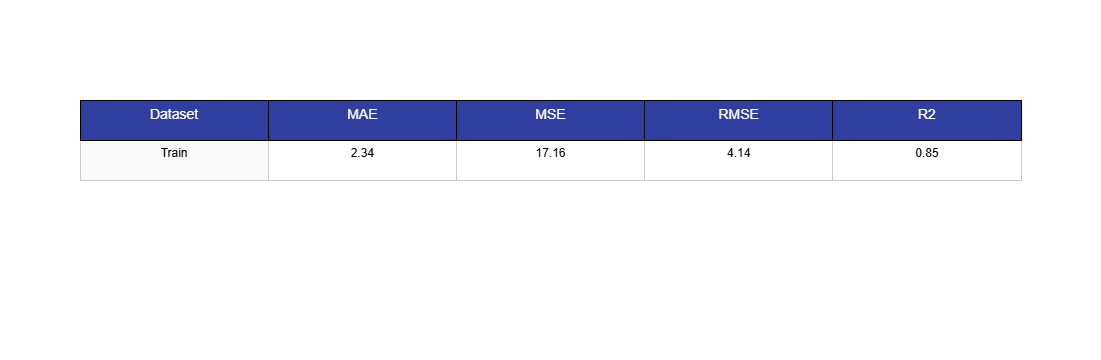

In [176]:
ul=create_table(error_rla,10,10)

In [177]:
error_rlat=evaluate_fitted_model_simple(best_model_r,X_test,y_test,"test")

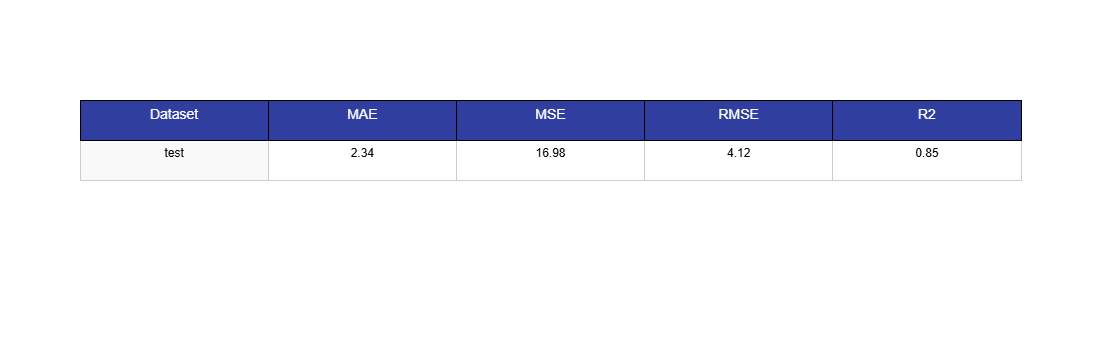

In [178]:
ult=create_table(error_rlat,10,10)

MAE : Les valeurs de MAE sont identiques pour les ensembles d'entraînement et de test (2.34), indiquant une performance cohérente en termes d'erreur absolue moyenne.
MSE : Les valeurs de MSE sont très proches (17.16 pour l'entraînement et 16.98 pour le test), suggérant une performance similaire en termes d'erreur quadratique moyenne.
RMSE : Les valeurs de RMSE sont également très proches (4.14 pour l'entraînement et 4.12 pour le test), indiquant une performance cohérente en termes d'erreur quadratique moyenne racine.
R2 : Les valeurs de R2 sont identiques (0.85) pour les deux ensembles, montrant que le modèle explique bien la variance des données réelles de manière cohérente sur les ensembles d'entraînement et de test.


<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto">Test de normalité et d'autocorrélation

In [181]:
test_normalite_residus_ks(residus_ridge)

Statistique KS: 0.1623, p-value: 0.0000
Les résidus ne suivent pas une distribution normale (p ≤ 0.05).


{'statistique': 0.16230468457135738,
 'p_value': 0.0,
 'interpretation': 'Les résidus ne suivent pas une distribution normale (p ≤ 0.05).'}

In [182]:
test_autocorrelation_residus(residus_ridge)

Pas d'autocorrélation détectée (statistique dans [1.5, 2.5]).


{'statistique': 2.0017710170812526,
 'interpretation': "Pas d'autocorrélation détectée (statistique dans [1.5, 2.5])."}

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto"> Représentation du résidus

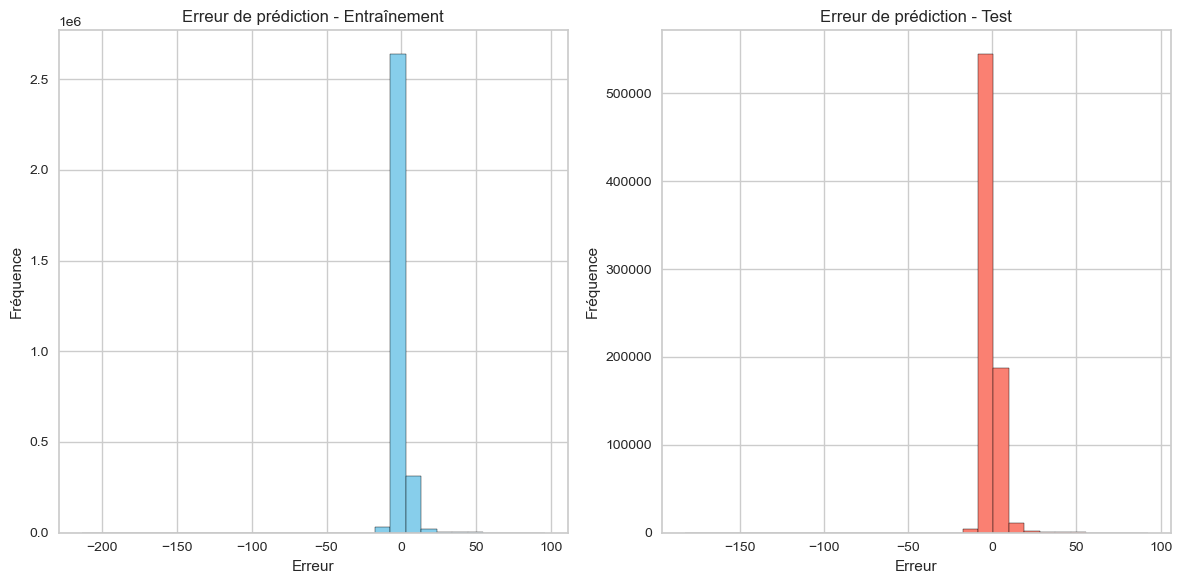

In [186]:
plot_prediction_errors(residus_ridge,residus_test_ridge)

Distribution des Erreurs : Les deux graphiques montrent une distribution similaire des erreurs de prédiction, avec une forte concentration autour de zéro. Cela indique que le modèle performe de manière cohérente sur les ensembles d'entraînement et de test.
Fréquence des Erreurs : La fréquence des erreurs est beaucoup plus élevée pour l'ensemble de test (graphique de droite) en raison de la taille plus grande de cet ensemble par rapport à l'ensemble d'entraînement.
Précision des Prédictions : La concentration des erreurs autour de zéro dans les deux graphiques montre que le modèle fait des prédictions précises pour la majorité des points de données dans les deux ensembles.

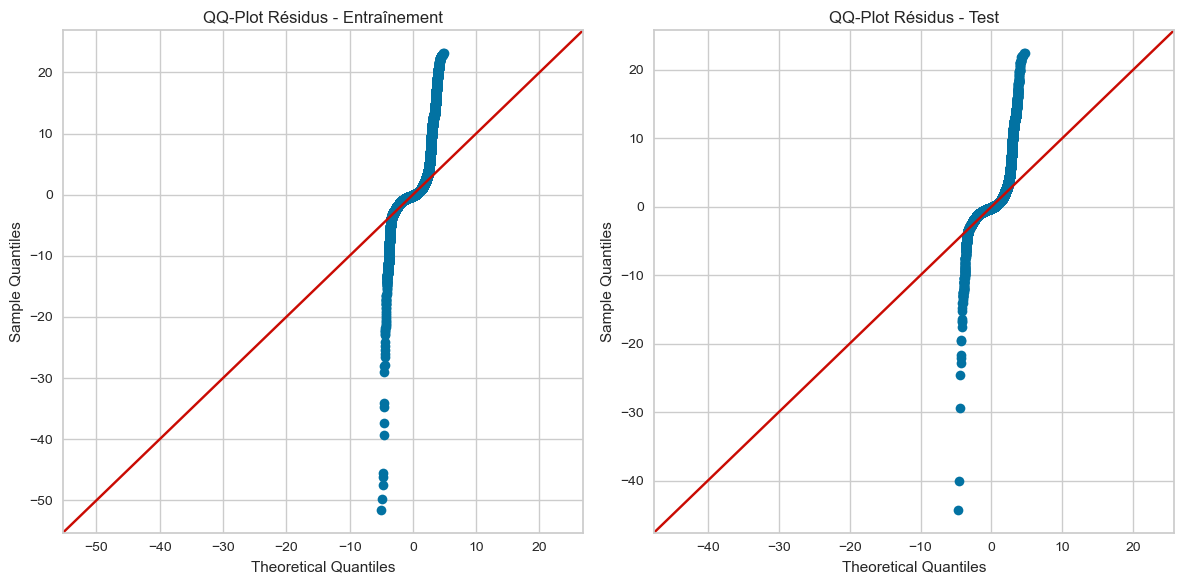

In [452]:
plot_qqplot_residuals(residus_ridge,residus_test_ridge)

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto"> Représentaton des valeurs prédict VS valeurs réelles

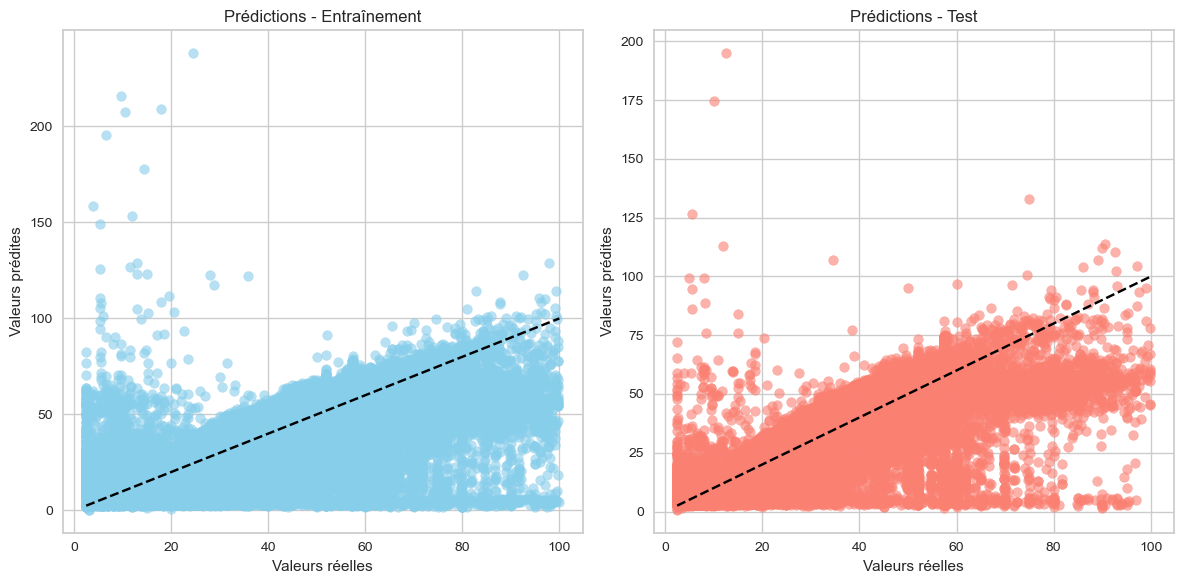

In [258]:
plot_scatter_comparison(ypl,ytl,tfl,ytfl)

- Performance pour les Petites Valeurs :
Le modèle performe bien pour les valeurs réelles inférieures à environ 50, tant dans l'ensemble d'entraînement que dans l'ensemble de test. Les points sont proches de la ligne d'identité (ligne en pointillés), ce qui indique que les prédictions sont proches des valeurs réelles. Cela montre que le modèle est précis pour les petites valeurs.- 

Performance pour les Grandes Valeurs :
Le modèle sous-estime systématiquement les valeurs réelles élevées (supérieures à 50). Les points s'éloignent de la ligne d'identité, ce qui montre que le modèle prédit des valeurs inférieures aux valeurs réelles pour ces observations. Cette tendance est observée à la fois dans l'ensemble d'entraînement et dans l'ensemble de tes- t.

Dispersion des Prédictions :
La dispersion des points autour de la ligne d'identité est plus large pour les valeurs réelles élevées, ce qui indique une précision moindre du modèle pour ces valeurs. Cela peut être dû à une variabilité plus grande dans les données ou à une moins bonne capacité du modèle à capturer les relations pour ces val- eurs.

Consistance entre Entraînement et Test :
Les schémas observés dans les deux graphiques sont similaires, ce qui suggère que le modèle généralise bien aux nouvelles données et ne surapprend pas les données d'entraînement. Les tendances de sous-estimation pour les grandes valeurs et de bonne performance pour les petites valeurs sont cohérentes entre les deux ensembles.



<h3 style="text-align:justify; background-color:RGB(135, 206, 250);font-size:25px;font-family:Roboto">Le modèle Lasso

### Variables explicatives

In [228]:
scaling_features = [   'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance', 'near_airport',
        'hour_cos', 'is_holiday']

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto">Mise en place du pipeline

In [231]:
pipeline_l = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('scaler', StandardScaler(), scaling_features)
        ],
        remainder='passthrough'  # Pour conserver les autres colonnes non spécifiées dans scaling_features
    )),
    ('lasso', Lasso())  # Modèle Lasso
])

### Paramètres d'optimisation

In [234]:
param_grid_l = {
    'lasso__alpha': [0,0.1,1]  # Plage de valeurs pour alpha
}

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto">Entrainement du modèle

In [237]:
grid_search_la = GridSearchCV(pipeline_l, param_grid_l, cv=3, scoring=make_scorer(r2_score), n_jobs=-1)
grid_search_la.fit(X_train, y_train)

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\base.py:1474: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: UserWarning:

Coordinate descent with no regularization may lead to unexpected results and is discouraged.

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.579e+07, tolerance: 3.506e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         ['pickup_longitude',
                                                                          'pickup_latitude',
                                                                          'dropoff_longitude',
                                                                          'dropoff_latitude',
                                                                          'passenger_count',
                                                                          'distance',
                                                                          'near_airport',
                                                                          'hour_cos',
                                                                          'is_holiday'])])),
                                       ('lasso', Lasso())]),
             n_jobs=-1, param_grid={'lasso__alpha': [0, 0.1, 1]},
             scoring=make_scorer(r2_score, response_method='predict'))

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto"> Représentation graphique des alpha vers les R2

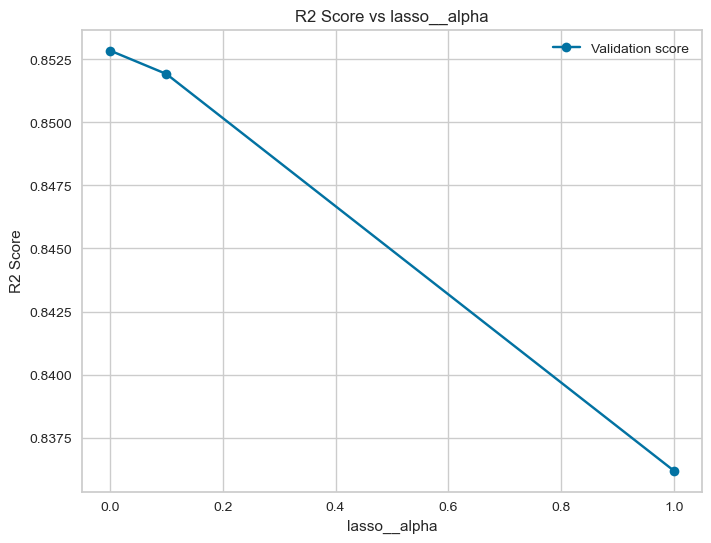

In [239]:
plot_grid_search_results(grid_search_la)

La courbe tracée révèle une tendance négative claire entre lasso_alpha et le score R². En d'autres termes, à mesure que la valeur de lasso_alpha augmente, le score R² diminue. Plus précisément, le score R² commence à environ 0.8525 pour un lasso_alpha de 0 et décroît jusqu'à environ 0.8375 pour un lasso_alpha de 1.

##### *Ainsi cette otimisation nous ramène dans le as d'une régression linéaire simple vu précedamment.*

La suite sera conforme à la régression linéaire simple vue précédemment, car le meilleur alpha pour notre paramètre vaut 0

### Recherche du meilleur modèle

In [262]:
best_model_lasso = grid_search_la.best_estimator_
ridge_model_l = best_model_r.named_steps['ridge']

### Les coefficients

In [265]:
coefficients_la=ridge_model_l.coef_

In [267]:
numerical_coefficients_df_lasso = pd.DataFrame({
    'Variable':scaling_features,
    'Coefficient':coefficients_la[0]
})

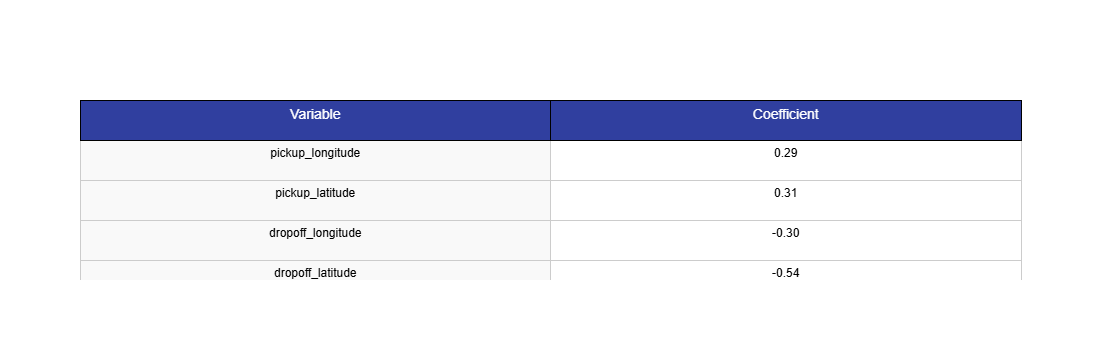

In [270]:
tabl_l=create_table(numerical_coefficients_df_lasso,10,10)

- *Effet de la Localisation* : Les coefficients de pickup_longitude, pickup_latitude, dropoff_longitude, et dropoff_latitude montrent que la localisation géographique de la prise en charge et de la dépose a un impact significatif sur le prix de la course. Les courses commençant à des longitudes et latitudes plus élevées sont plus coûteuses, tandis que celles se terminant à des longitudes et latitudes plus élevées sont moins coûteuses.

- *Effet du Nombre de Passagers* : Le coefficient de passenger_count indique que le nombre de passagers a un effet positif mais modeste sur le prix de la course.

- *Effet de la Distance* : Le coefficient de distance montre que la distance parcourue est le facteur le plus influent sur le prix de la course, ce qui est logique car les courses plus longues nécessitent plus de temps et de carburant.

- *Effet de la Proximité de l'Aéroport* : Le coefficient de near_airport suggère que les courses près de l'aéroport sont légèrement plus coûteuses, probablement en raison d'une demande accrue ou de frais supplémentaires.

- *Effet de l'Heure de la Journée* : Le coefficient de hour_cos indique que les courses pendant les heures les nuits sont moins coûteuses, ce qui pourrait refléter des périodes de faible demande.

- *Effet des Jours Fériés* : Le coefficient de is_holiday montre que les courses pendant les jours fériés sont légèrement moins coûteuses, peut-être en raison d'une demande réduite ou de promotions spéciales.

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto"> Prédictions et calcul des résidus

In [274]:
y_pred4 = best_model_lasso.predict(X_train)
y_pred_test_4 = best_model_lasso.predict(X_test)

In [276]:
residus_lasso=cal_residus( y_train,y_pred4)
residus_test_lasso=cal_residus(y_test,y_pred_test_la)


In [278]:
ytr,ypr=flatten_predictions(y_train,y_pred2)
ytfr,tfr=flatten_predictions(y_test,y_pred_test_la)

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto"> Performance du modèle

In [281]:
error_r_lasso=evaluate_fitted_model_simple(best_model_lasso,X_train,y_train)

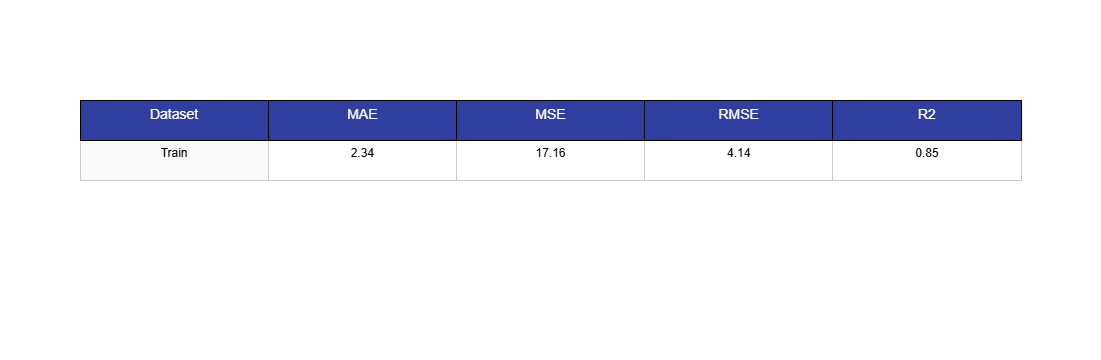

In [283]:
g=create_table(error_r_lasso,10,10)

In [285]:
error_r_test_lasso=evaluate_fitted_model_simple(best_model_lasso,X_test,y_test,"test")

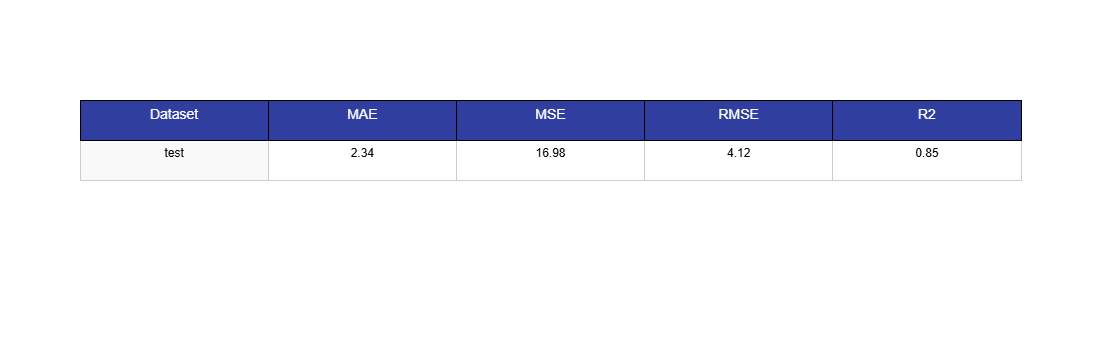

In [287]:
g_lasso=create_table(error_r_test_lasso,10,10)

Le modèle KNN semble performer de manière très similaire sur les données d'entraînement et de test, avec des métriques d'erreur presque identiques et un R2 constant. Cela indique que le modèle généralise bien et ne montre pas de signe de surapprentissage (overfitting) ou de sous-apprentissage (underfitting). Les valeurs de R2 de 0.85 montrent que le modèle capture bien la variance des données, bien que des améliorations soient possibles pour atteindre un R2 plus proche de 1.

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto"> Test de normalité et d'autocorrélation

In [291]:
test_normalite_residus_ks(residus_lasso)

Statistique KS: 0.1623, p-value: 0.0000
Les résidus ne suivent pas une distribution normale (p ≤ 0.05).


{'statistique': 0.16230454022417684,
 'p_value': 0.0,
 'interpretation': 'Les résidus ne suivent pas une distribution normale (p ≤ 0.05).'}

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto">Représentation de l'histogramme du residus

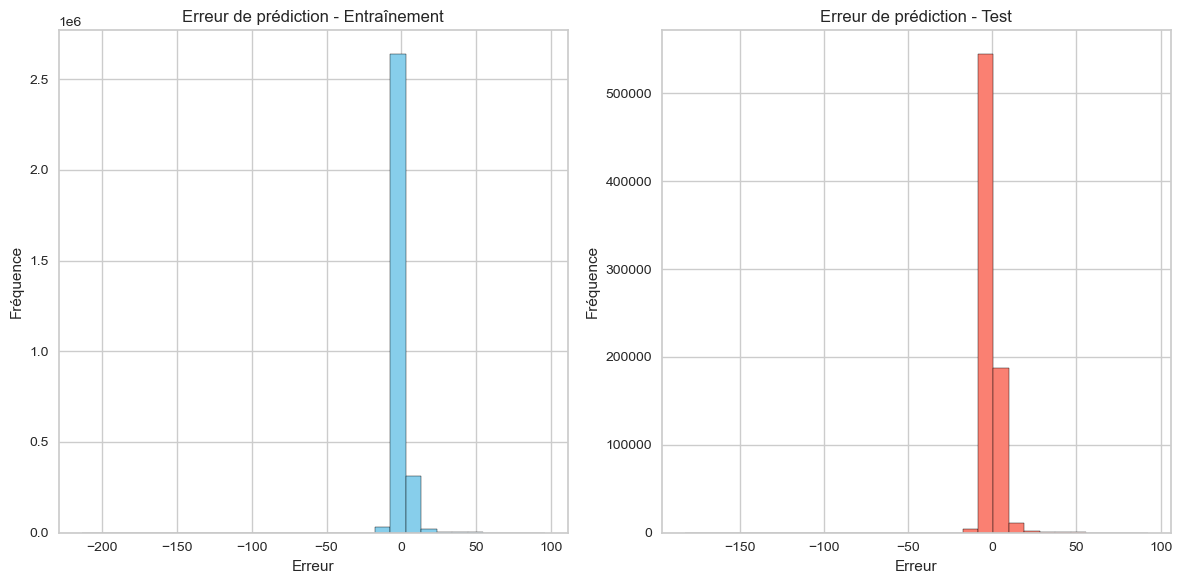

In [294]:
plot_prediction_errors(residus_lasso,residus_test_lasso)

Les graphiques montrent que le modèle KNN performe bien pour des valeurs réelles inférieures à 100, tant sur l'ensemble d'entraînement que sur l'ensemble de test. Cependant, le modèle tend à sous-estimer les valeurs réelles élevées, ce qui indique une limitation dans sa capacité à prédire correctement les valeurs extrêmes. Cette tendance est cohérente entre les deux ensembles de données, suggérant que le modèle généralise bien mais pourrait bénéficier d'améliorations pour mieux gérer les valeurs élevées. Il serait utile d'explorer des techniques de prétraitement des données, comme la normalisation ou la transformation des variables, ou d'ajuster les hyperparamètres du modèle pour améliorer ses performances sur les valeurs extrêmes.

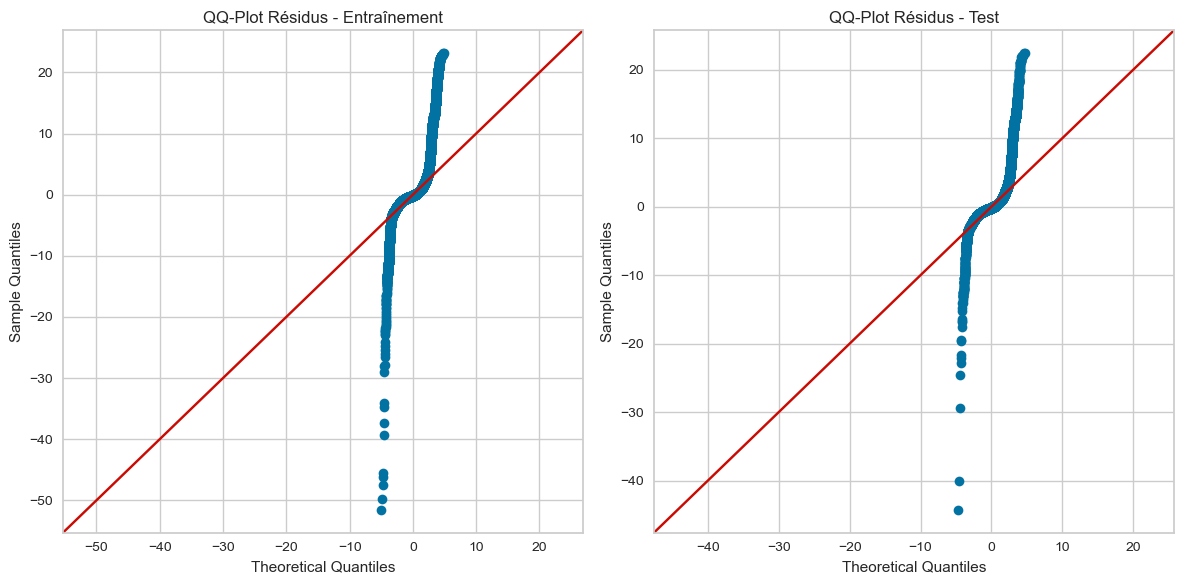

In [456]:
plot_qqplot_residuals(residus_lasso,residus_test_lasso)

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto">Représentation des valeurs prédictes vers vraie valeurs

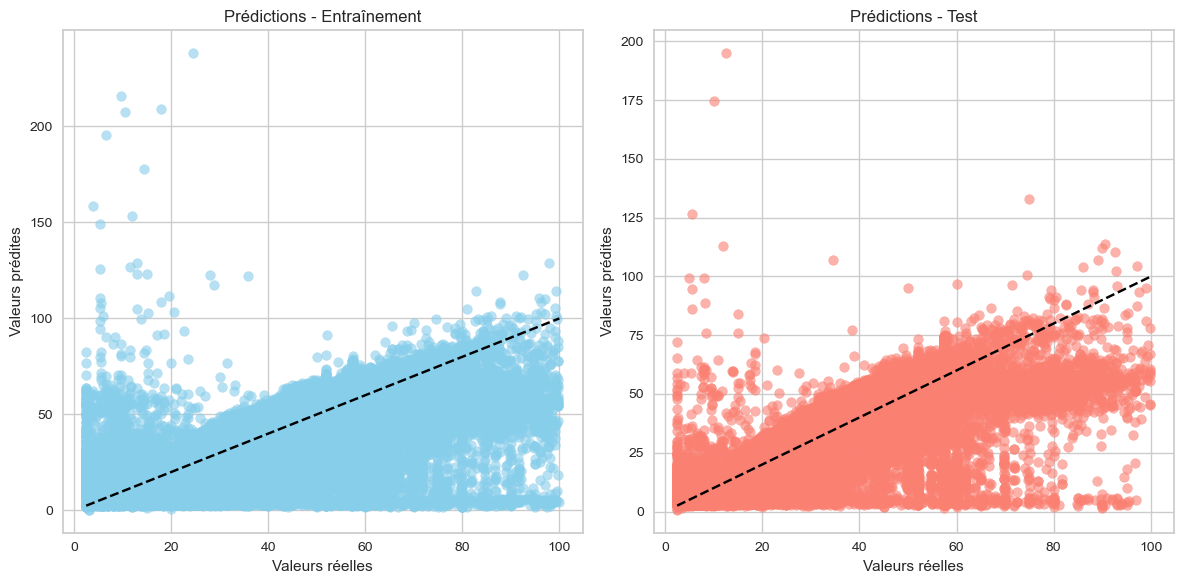

In [298]:
plot_scatter_comparison(ypr,ytr,tfr,ytfr)

- Performance pour les Petites Valeurs :
Le modèle performe bien pour les valeurs réelles inférieures à environ 50, tant dans l'ensemble d'entraînement que dans l'ensemble de test. Les points sont proches de la ligne d'identité (ligne en pointillés), ce qui indique que les prédictions sont proches des valeurs réelles. Cela montre que le modèle est précis pour les petites valeurs.- 

Performance pour les Grandes Valeurs :
Le modèle sous-estime systématiquement les valeurs réelles élevées (supérieures à 50). Les points s'éloignent de la ligne d'identité, ce qui montre que le modèle prédit des valeurs inférieures aux valeurs réelles pour ces observations. Cette tendance est observée à la fois dans l'ensemble d'entraînement et dans l'ensemble de tes- t.

Dispersion des Prédictions :
La dispersion des points autour de la ligne d'identité est plus large pour les valeurs réelles élevées, ce qui indique une précision moindre du modèle pour ces valeurs. Cela peut être dû à une variabilité plus grande dans les données ou à une moins bonne capacité du modèle à capturer les relations pour ces val- eurs.

Consistance entre Entraînement et Test :
Les schémas observés dans les deux graphiques sont similaires, ce qui suggère que le modèle généralise bien aux nouvelles données et ne surapprend pas les données d'entraînement. Les tendances de sous-estimation pour les grandes valeurs et de bonne performance pour les petites valeurs sont cohérentes entre les deux ensembles.

<h3 style="text-align:justify; background-color:RGB(135, 206, 250);font-size:25px;font-family:Roboto"> KNN

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto"> Mise en place du pipeline

In [305]:
pipeline_k = Pipeline([
    ('scaler', StandardScaler()),        # Étape de mise à l'échelle
    ('knn', KNeighborsRegressor())       # Modèle KNN
])

param_grid_kk = {
    'knn__n_neighbors': [3],    # Nombre de voisins
    'knn__weights': ['uniform', 'distance'],  # Poids des voisins
    'knn__metric': ['euclidean']  # Distance utilisée
}

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto"> Le modèle 

In [308]:
grid_search_kk = GridSearchCV(
    estimator=pipeline_k,
    param_grid=param_grid_kk,
    cv=2,                               # Validation croisée
    scoring='neg_mean_squared_error',   # Critère d'évaluation
    verbose=2
)

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto"> Entrainement du modele

In [311]:
grid_search_kk.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform; total time=12.8min
[CV] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform; total time=13.9min
[CV] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=distance; total time=16.5min
[CV] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=distance; total time=13.7min


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__metric': ['euclidean'], 'knn__n_neighbors': [3],
                         'knn__weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error', verbose=2)

<h3 style="text-align:justify; background-color:RGB(135, 206, 250);font-size:25px;font-family:Roboto">Recherche du meilleur modele

In [328]:
best_model_k= grid_search_kk.best_estimator_

# Utiliser le modèle pour prédire


<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto">Prediction et calcul des erreurs

In [331]:
y_pred_k=best_model_k.predict(X_train)
y_pred_test_k=best_model_k.predict(X_test)

In [333]:
residus_k=cal_residus(y_train,y_pred_k)
residus_test_k=cal_residus(y_test,y_pred_test_k)

In [361]:
tf,y=flatten_predictions(y_train,y_pred_k)
tt,yt=flatten_predictions(y_test,y_pred_test_k)

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto">Calcul du score

In [338]:
error_k=evaluate_fitted_model_simple(best_model_k,X_train,y_train)

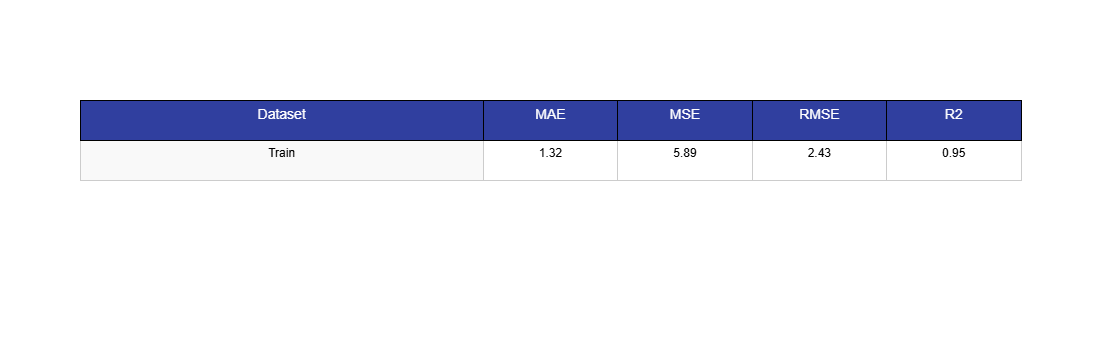

In [339]:
o=create_table(error_k)

In [340]:
error_k_test=evaluate_fitted_model_simple(best_model_k,X_test,y_test,"Test")

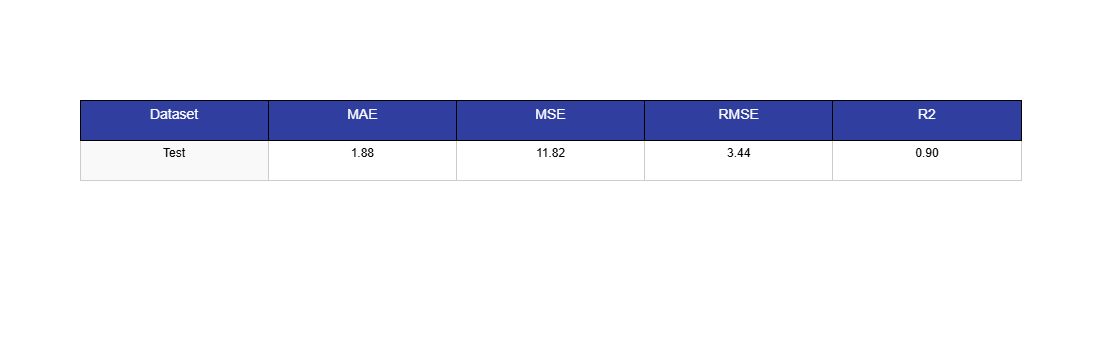

In [341]:
tt=create_table(error_k_test,10,10)

Le modèle KNN semble bien performer sur les données d'entraînement, avec des métriques d'erreur relativement faibles et un R2 élevé. Cependant, il y a une légère dégradation des performances sur les données de test, ce qui est attendu et indique que le modèle généralise bien mais avec une précision légèrement réduite. Les valeurs de R2 proches de 1 pour les deux ensembles de données montrent que le modèle capture bien la variance des données.

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto">Test de normalité et d'autocorrélation

In [352]:
test_normalite_residus_ks(residus_k)

Statistique KS: 0.1560, p-value: 0.0000
Les résidus ne suivent pas une distribution normale (p ≤ 0.05).


{'statistique': 0.15597990790742655,
 'p_value': 0.0,
 'interpretation': 'Les résidus ne suivent pas une distribution normale (p ≤ 0.05).'}

In [359]:
test_autocorrelation_residus(residus_k)

Pas d'autocorrélation détectée (statistique dans [1.5, 2.5]).


{'statistique': 2.000773798884459,
 'interpretation': "Pas d'autocorrélation détectée (statistique dans [1.5, 2.5])."}

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto"> Distribution des résidus

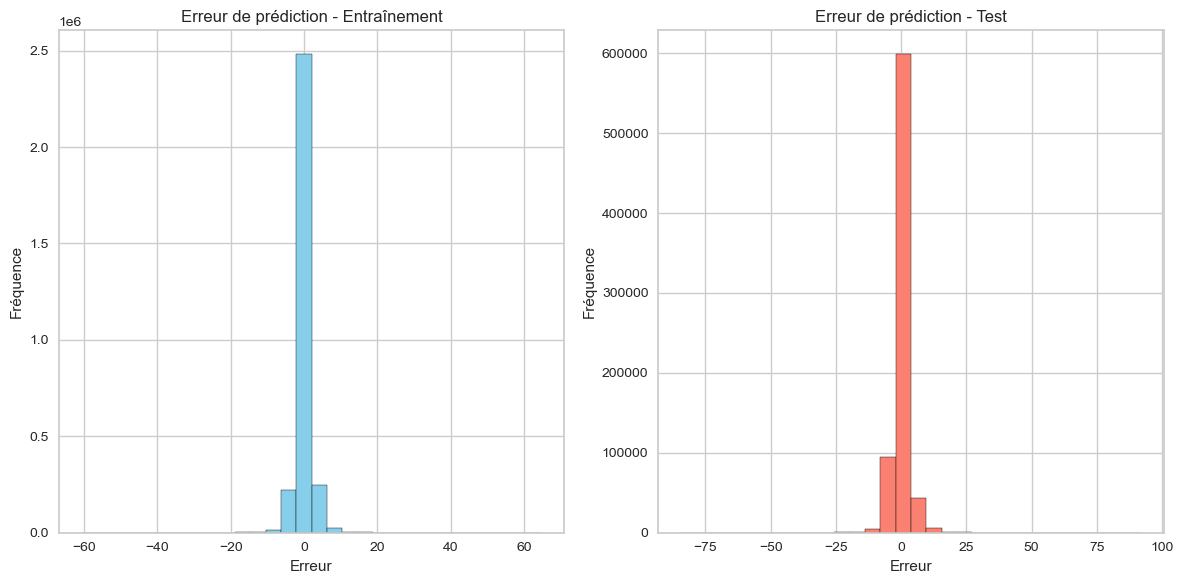

In [345]:
plot_prediction_errors(residus_k,residus_test_k)

Ces histogrammes montrent que le modèle a une bonne performance sur l'ensemble d'entraînement, avec des erreurs fortement concentrées autour de 0. Cependant, la performance sur l'ensemble de test est légèrement moins bonne, avec une dispersion plus large des erreurs. 

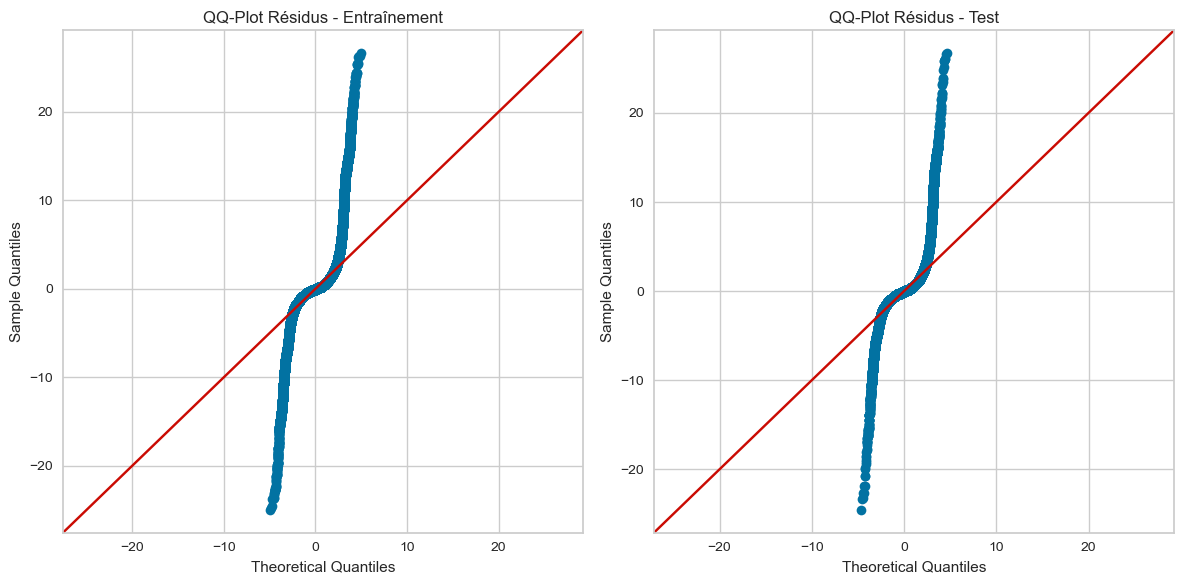

In [459]:
plot_qqplot_residuals(residus_k,residus_test_k)

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto">Représentation des valeurs predictes VS valueurs réelles

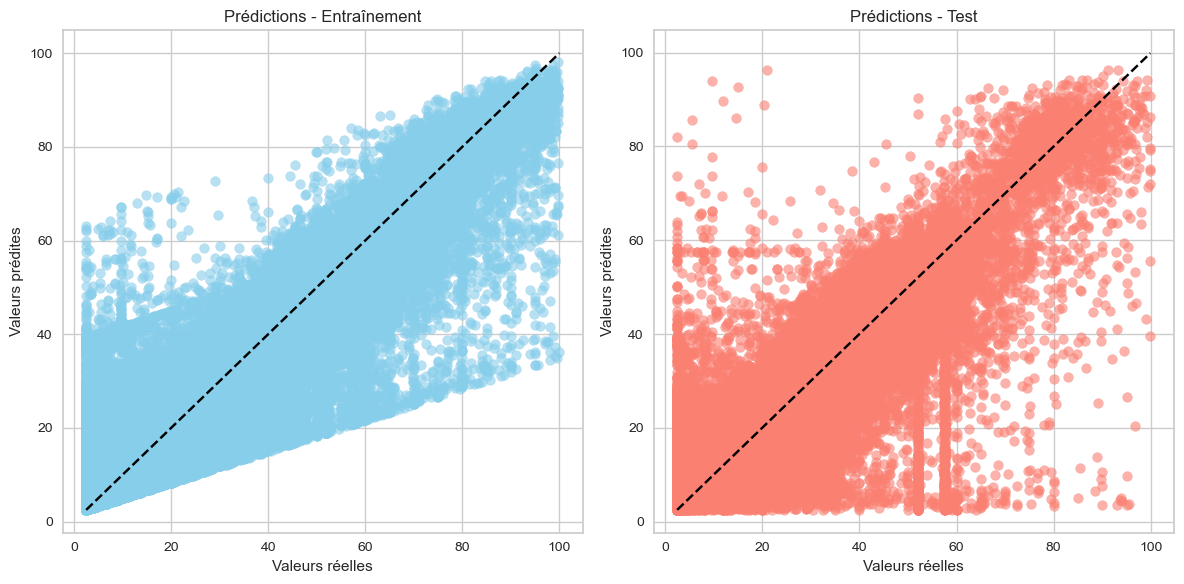

In [363]:
plot_scatter_comparison(y,tf,yt,tt)

Les schémas observés dans les deux graphiques sont similaires, ce qui suggère que le modèle généralise bien aux nouvelles données et ne surapprend pas les données d'entraînement. Les tendances de sous-estimation pour les grandes valeurs et de bonne performance pour les petites valeurs sont cohérentes entre les deux ensembles.

Quelques valeurs réelles très élevées (supérieures à 80) sont présentes dans les deux ensembles, et le modèle les sous-estime de manière significative. Celut indiqer la présence de valeurs aberrantes ou des difficultés du modèle à prédire des valeurs extrêmes. La densité des points est plus élevée pour les valeurs réelles inférieures à 50, ce qui suggère que la majorité des observations se situent dans cette plage. Le modèle semble mieux performer dans cette plage de valeurs plus fréquentes.mé, le modèle KNN montre une bonne performance pour les petites valeurs mais tend à sous-estimer les valeurs réelles élevées. La dispersion des prédictions est plus importante pour les grandes valeurs, indiquant une précision moindre dans ces cas. La cohérence entre les ensembles d'entraînement et de test suggère que le modèle généralise bien aux nouvelles donnurs.


In [ ]:
plot_prediction_errors(residus_k,residus_test_k)

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto">Le modèle XGBoost

In [365]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor

In [367]:
numerical_features_x = ['passenger_count', 'distance']

# Prétraitement pour les colonnes numériques
numerical_transformer_x = StandardScaler()


In [369]:
# Appliquer le prétraitement aux colonnes numériques
preprocessor_x = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_x, numerical_features_x)
    ])

In [371]:
# Étape 2 : Pipeline complet avec XGBoost
pipeline_x = Pipeline(steps=[
    ('preprocessor', preprocessor_x),
    ('model', XGBRegressor(random_state=42))  # ou XGBClassifier pour classification
])


In [373]:
# Étape 3 : Définir la grille de recherche pour optimiser les hyperparamètres
param_grid_x = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [3, 5],
    'model__learning_rate': [ 0.1],
    'model__subsample': [ 1.0]
}

In [375]:
# Étape 4 : Recherche d’hyperparamètres
grid_search_x = GridSearchCV(
    pipeline_x, param_grid_x, cv=2, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1
)

In [377]:
# Étape 5 : Ajustement du modèle
grid_search_x.fit(X_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['passenger_count',
                                                                          'distance'])])),
                                       ('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     ev...
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.1],
                         'model__max_depth': [3, 5],
                         'model__n_estimators': [50, 100],
                         'model__subsample': [1.0]},
             scoring='neg_mean_squared_error', verbose=2)

In [378]:
# Meilleurs paramètres
print("Meilleurs paramètres :", grid_search_x.best_params_)

Meilleurs paramètres : {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100, 'model__subsample': 1.0}


In [379]:
# Évaluation sur les données de test
best_modelx = grid_search_x.best_estimator_

In [380]:
# prediction
y_pred_x = best_modelx.predict(X_train)

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto"> Calcul des predictions et des erreurs

In [386]:
y_pred_x = best_modelx.predict(X_train)
y_pred_test_x = best_modelx.predict(X_test)

In [387]:
residus_x=cal_residus(y_train,y_pred_x)
residus_test_x=cal_residus(y_test,y_pred_test_x)

In [424]:
txu,yx=flatten_predictions(y_train,y_pred_x)
txt,yxt=flatten_predictions(y_test,y_pred_test_k)

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto">Calcul du score

In [429]:
error_x=evaluate_fitted_model_simple(best_modelx,X_train,y_train)

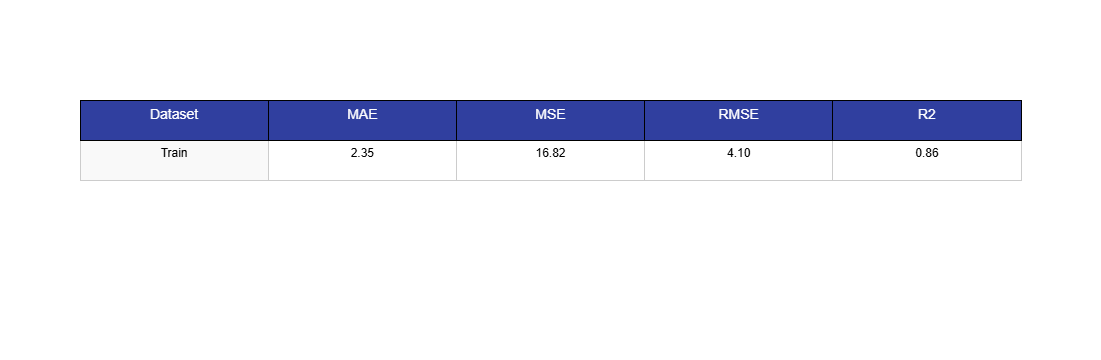

In [430]:
tx=create_table(error_x,10,10)

In [402]:
error_x_test=evaluate_fitted_model_simple(best_modelx,X_test,y_test,"Test")

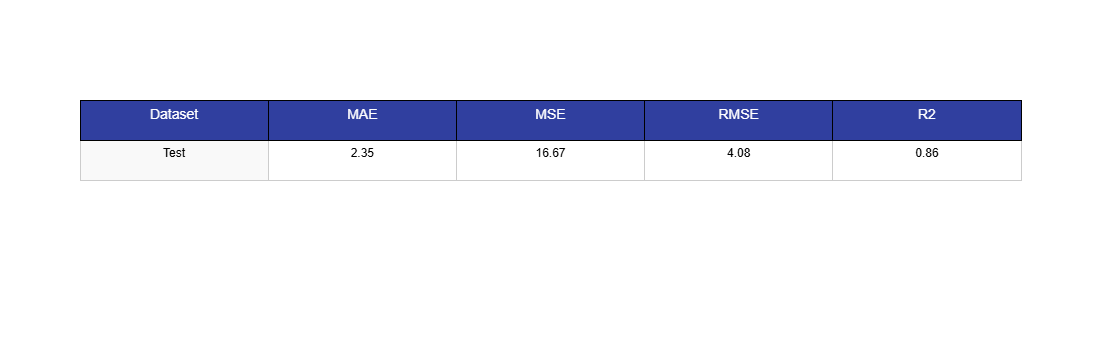

In [404]:
ttt=create_table(error_x_test,10,10)

In [414]:
test_normalite_residus_ks(residus_x)

Statistique KS: 0.1537, p-value: 0.0000
Les résidus ne suivent pas une distribution normale (p ≤ 0.05).


{'statistique': 0.1537389456313698,
 'p_value': 0.0,
 'interpretation': 'Les résidus ne suivent pas une distribution normale (p ≤ 0.05).'}

In [408]:
test_autocorrelation_residus(residus_x)

Pas d'autocorrélation détectée (statistique dans [1.5, 2.5]).


{'statistique': 2.001483219814054,
 'interpretation': "Pas d'autocorrélation détectée (statistique dans [1.5, 2.5])."}

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto">Representation des valeurs predictes vers VS valeurs réelles

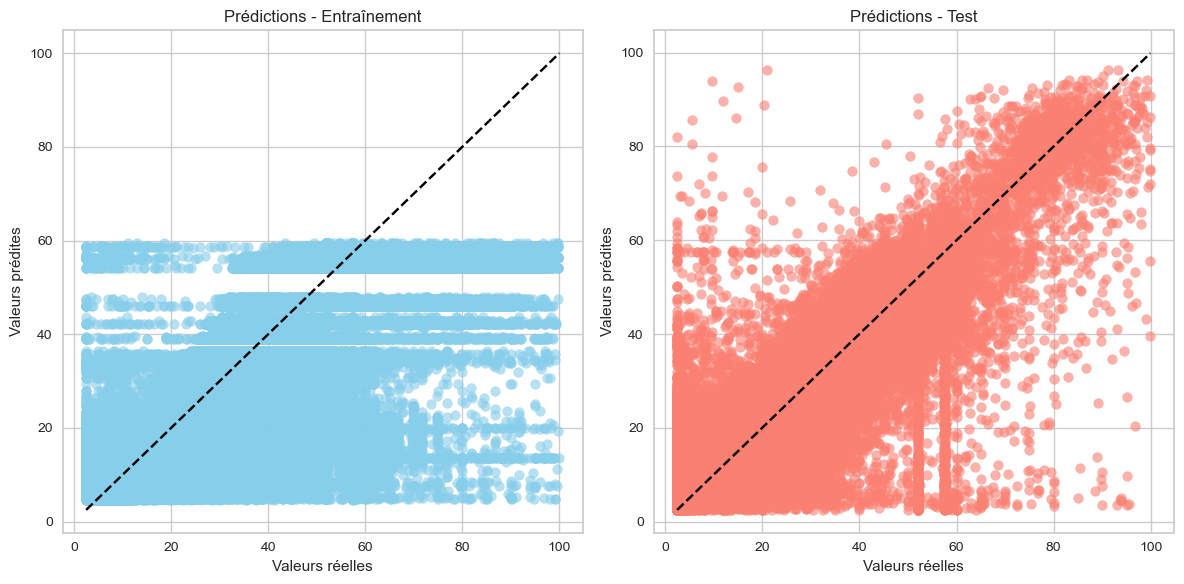

In [426]:
plot_scatter_comparison(yx,txu,yxt,txt)

Pour l'ensemble d'entraînement, on observe une concentration importante des points autour de certaines valeurs spécifiques, ce qui suggère que le modèle prédit fréquemment les mêmes valeurs pour différentes valeurs réelles. La dispersion des points autour de la ligne diagonale (y = x) montre que bien que les prédictions ne soient pas parfaites, il existe une certaine corrélation avec les valeurs réelles. Cependant, le modèle semble sous-estimer de manière significative les données avec de grandes valeurs, ce qui peut indiquer un manque de précision dans la prédiction des extrêmes.

En revanche, pour l'ensemble de test, les points sont plus dispersés, indiquant une moins bonne performance du modèle sur ces données. Bien que les valeurs prédites augmentent généralement avec les valeurs réelles, la plus grande dispersion des points autour de la ligne diagonale suggère une généralisation moins efficace sur les données de test.

Ces observations suggèrent un phénomène de surapprentissage (overfitting), où le modèle semble avoir mémorisé les données d'entraînement au lieu d'apprendre des tendances généralisables. Cette surspécialisation du modèle pourrait expliquer la moins bonne précision sur les données de test.

Pour améliorer les performances du modèle, il serait pertinent d'explorer des méthodes de régularisation, d'ajuster les hyperparamètres ou d'augmenter la taille de l'ensemble de données d'entraînement afin de favoriser une meilleure généralisation.

<h3 style="text-align:justify; background-color:RGB(230, 230, 250);font-size:25px;font-family:Roboto">Distribution des residus

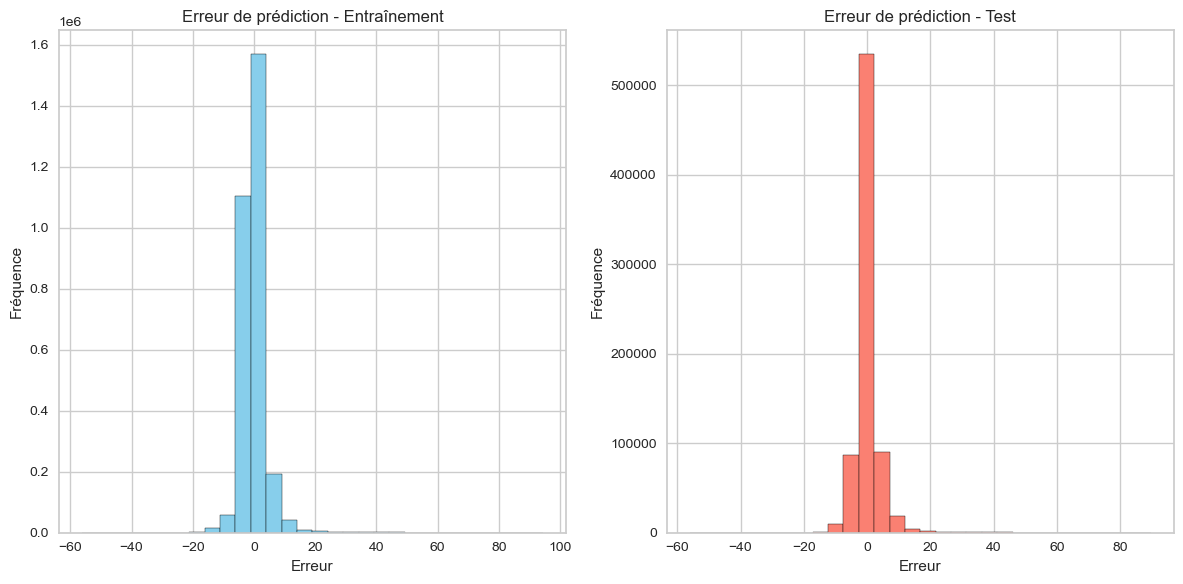

In [420]:
plot_prediction_errors(residus_x,residus_test_x)

Performance du Modèle : Les deux graphiques montrent que le modèle présente des performances similaires sur les ensembles d’entraînement et de test, ce qui suggère une bonne capacité de généralisation.
Distribution des Erreurs : La symétrie des erreurs autour de zéro pour les deux ensembles est un signe positif, car elle montre l’absence de biais systématique dans les prédictions.

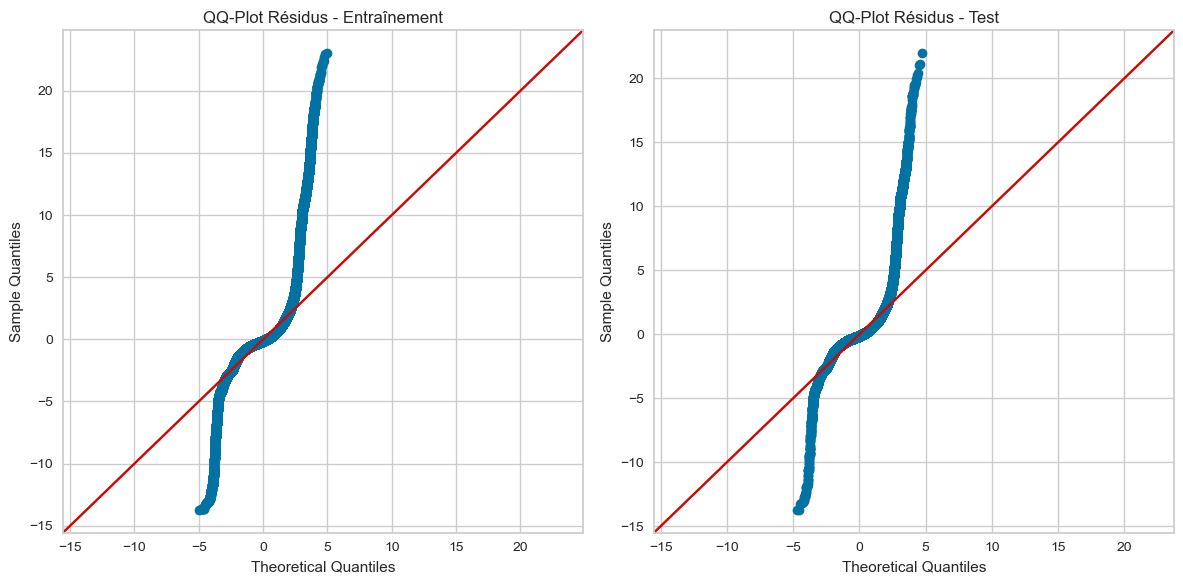

In [461]:
plot_qqplot_residuals(residus_x,residus_test_x)

<h3 style="text-align:justify; background-color:RGB(135, 206, 250);font-size:25px;font-family:Roboto"> Choix du modèle

Parmi les modèles évalués, K-Nearest Neighbors (KNN) se distingue clairement par ses performances :

-R² élevé : 0.95 sur l’ensemble d’entraînement et 0.90 sur l’ensemble de test.
-Erreurs faibles : Le MAE, MSE et RMSE sont significativement plus bas que ceux des autres modèles.

Le modèle K-Nearest Neighbors (KNN) est le meilleur modèle parmi ceux testés. Il offre des prédictions plus précises et une meilleure capacité de généralisation, comme l’indiquent les métriques de performance. 

<h3 style="text-align:justify; background-color:RGB(135, 206, 250);font-size:25px;font-family:Roboto"> Telechargement du bon modele

In [2]:
import joblib

In [185]:
joblib.dump(best_model_k, 'model.pkl')

['model.pkl']